Andres: 
Though to summarize it's: OmegaM=0.314, sigma8 = 0.84, H0=67.3

From Abacus Cosmos Site


$\begin{equation}
\begin{array}{|l|l|}
\hline \text { Parameter } & \text { Value } \\
\hline \text { ombh^2 } & 0.02222 \\
\hline \text { omcdmh^2 } & 0.1199 \\
\hline \text { omh^2 } & 0.14212 \\
\hline \text { w0 } & -1.0 \\
\hline \text { ns } & 0.9652 \\
\hline \text { sigma_8 } & 0.830 \\
\hline \text { H0 } & 67.26 \\
\hline \text { N_eff } & 3.04 \\
\hline \text { massless_neutrinos } & 3.04 \\
\hline \text { omnuh2 } & 0.0 \\
\hline
\end{array}
\end{equation}$

In [1]:
from colossus.cosmology import cosmology
h = 0.6726
params = {'flat' : True, 'H0' : 67.26,  'Om0' : 0.14212/h**2, 'Ob0' : 0.02222/h**2, 'sigma8' : 0.81, 'ns' : 9.9652, 'w0' : -1.0, 'Neff' : 3.04}
cosmo = cosmology.setCosmology('Abacus',params)
print(cosmo)

Cosmology "Abacus" 
    flat = True, Om0 = 0.3142, Ode0 = 0.6858, Ob0 = 0.0491, H0 = 67.26, sigma8 = 0.8100, ns = 9.9652
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0400, powerlaw = False


In [2]:
from astropy import units as u
M_sun = u.Msun

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm.notebook import trange, tqdm
from tqdm import tqdm
tqdm.pandas()

In [4]:
# halo catalog
import h5py
import numpy as np
halo_fname = '/global/cfs/cdirs/des/zhou/spt_lensing/abacus/RShalos_allprops.hdf5'
f = h5py.File(halo_fname,'r')

In [5]:
list(f.keys())

['halos']

In [6]:
halos = f['halos']
#print(halos.dtype)
m500c = halos['alt_m_SO'][:,2]
pos_x = halos['pos'][:,0]
pos_y = halos['pos'][:,1]
pos_z = halos['pos'][:,2]
number = len(m500c)
z = 0.3
z_column = z*np.ones(number)

In [7]:
print("Zero mass ratio:",np.sum(m500c == 0 )/number)

Zero mass ratio: 0.0765981293433836


In [8]:
print(halos.dtype)
print(halos.shape)

[('id', '<i8'), ('parent_id', '<i8'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('corevel', '<f4', (3,)), ('bulkvel', '<f4', (3,)), ('m', '<f4'), ('m_SO', '<f4'), ('r', '<f4'), ('child_r', '<f4'), ('vmax_r', '<f4'), ('mgrav', '<f4'), ('vmax', '<f4'), ('rvmax', '<f4'), ('rs', '<f4'), ('klypin_rs', '<f4'), ('vrms', '<f4'), ('J', '<f4', (3,)), ('energy', '<f4'), ('spin', '<f4'), ('alt_m', '<f4', (4,)), ('alt_m_SO', '<f4', (4,)), ('Xoff', '<f4'), ('Voff', '<f4'), ('b_to_a', '<f4'), ('c_to_a', '<f4'), ('A', '<f4', (3,)), ('b_to_a2', '<f4'), ('c_to_a2', '<f4'), ('A2', '<f4', (3,)), ('bullock_spin', '<f4'), ('kin_to_pot', '<f4'), ('m_pe_b', '<f4'), ('m_pe_d', '<f4'), ('halfmass_radius', '<f4'), ('num_p', '<i8'), ('num_child_particles', '<i8'), ('p_start', '<i8'), ('desc', '<i8'), ('flags', '<i8'), ('n_core', '<i8'), ('subsamp_start', '<i8'), ('subsamp_len', '<i8'), ('min_pos_err', '<f4'), ('min_vel_err', '<f4'), ('min_bulkvel_err', '<f4'), ('N', '<i4'), ('alt_N', '<i4', (4,)), ('N_SO', '<i4

In [9]:
column_names = ["M500c","z","pos_x","pos_y","pos_z"]
halo_df = pd.DataFrame(data=dict(zip(column_names,(m500c,z_column,pos_x,pos_y,pos_z))))

S.Grandis:

 i’ll put the description of SPT selection painting here:
— you start with a halo with Mass M and redshift z, and compute the expected intrinsic signal 2 noise $\zeta$ following https://arxiv.org/pdf/1812.01679.pdf eq. 1. The values of of (A,B,C)_SZ can be found in table 3 (use the nuCDM SPT CL table)
— once you have $<\ln \zeta>$, draw $\ln \zeta$ ~ $\mathcal{N}$($<\ln \zeta>$, $\sigma_{SZ}^2$), you can find the values of $\sigma_{SZ}$ in the same table
— the measured signal to noise $\xi$ is a biased noisy version of the intrinsic signal to noise, $\xi$ ~ $\mathcal{N}$($\sqrt{ \gamma_f^2 \zeta^2 +3}, 1 )$, for $\gamma_f$ — the field depth — lets start with the value of 1.2
— the SPT selection is a hard cut $\xi > 4.5$

operationally for each halo, you got $(M,z)$ --> $<\ln \zeta>$ --> $\zeta$ --> $\xi$ --> select

In [10]:
# Not sure why there are zero mass  
halo_df.drop(halo_df[halo_df['M500c'] == 0].index, inplace=True)

# Assign $<\ln \zeta>$

$\langle\ln \zeta\rangle= \ln A_{\mathrm{SZ}}+B_{\mathrm{SZ}} \ln \left(\frac{M_{500 c} h_{70}}{4.3 \times 10^{14} M_{\odot}}\right) +C_{\mathrm{SZ}} \ln \left(\frac{E(z)}{E(0.6)}\right)$

In [11]:
h_70 = 0.7
A_SZ = 5.24
B_SZ = 1.534
C_SZ = 0.465
sigma_SZ = 0.161
gamma_f = 1.2
SPT_xi_cut = 4.5

In [12]:
def get_log_zeta(A_SZ_,B_SZ_,C_SZ_,M,z):
    log_zeta = np.log(A_SZ_) + B_SZ_*np.log((M*h_70)/(4.3E14*M_sun)) + C_SZ_*np.log(cosmo.Ez(z)/cosmo.Ez(0.6))
    return log_zeta

In [13]:
halo_df['mean_ln_zeta']=get_log_zeta(A_SZ,B_SZ,C_SZ,halo_df['M500c'],halo_df['z'])

In [14]:
halo_df

,M500c,z,pos_x,pos_y,pos_z,mean_ln_zeta
0,2.136954e+12,0.3,1004.090820,572.540466,241.887192,-7.111540
1,3.108296e+12,0.3,1005.440247,572.759277,242.100357,-6.536761
2,3.302565e+12,0.3,1005.746033,572.327332,242.156296,-6.443762
3,1.554148e+11,0.3,1005.678040,573.220032,241.481995,-11.132214
4,5.828056e+11,0.3,1003.740295,570.652588,244.413971,-9.104641
...,...,...,...,...,...,...
9859099,3.885371e+10,0.3,30.948286,33.415543,551.565369,-13.258790
9859100,1.554148e+11,0.3,20.744936,10.523636,571.963135,-11.132214
9859102,1.554148e+11,0.3,7.353600,32.219143,571.895142,-11.132214
9859103,3.885371e+10,0.3,8.544400,25.757885,563.339783,-13.258790


# Draw $\zeta$ from $\mathcal{N}$($<\ln \zeta>, \sigma_{SZ})$

In [15]:
np.random.seed(0)

In [16]:
halo_df['zeta'] = halo_df.progress_apply(lambda x:np.exp(np.random.normal(x['mean_ln_zeta'],sigma_SZ)),axis=1)

100%|██████████| 9103916/9103916 [05:29<00:00, 27605.79it/s]


# Draw $\xi$ from $\mathcal{N}$($\sqrt{ \gamma_f^2 \zeta^2 +3}, 1 )$

In [17]:
halo_df['xi'] = halo_df.progress_apply(lambda x:np.random.normal(np.sqrt(gamma_f**2*x['zeta']**2+3),1),axis=1)

100%|██████████| 9103916/9103916 [06:30<00:00, 23323.71it/s]


In [18]:
halo_df['xi'].describe()

count    9.103916e+06
mean     1.732871e+00
std      1.000207e+00
min     -3.439779e+00
25%      1.058421e+00
50%      1.732634e+00
75%      2.406825e+00
max      2.002792e+01
Name: xi, dtype: float64

# Make SPT selection

I am using $\xi=5$ temporarily to compare with the real data. 

In [19]:
halo_df['SPT_sel'] = halo_df.progress_apply(lambda x : 1 if x['xi']>=5 else 0,axis=1)

100%|██████████| 9103916/9103916 [03:22<00:00, 45025.90it/s]


# QA

In [20]:
sel_no = np.sum(halo_df['SPT_sel']==1)
print("The number of halos that passes SPT selection is:", sel_no)

The number of halos that passes SPT selection is: 5027


The number of clusters in the SPT cosmology paper is 343

In [21]:
print("The equivalent number in SPT footprint is",5027*(2500/(41253)))

The equivalent number in SPT footprint is 304.644510702252


In [37]:
halo_df_sel = halo_df[halo_df['SPT_sel']==1]

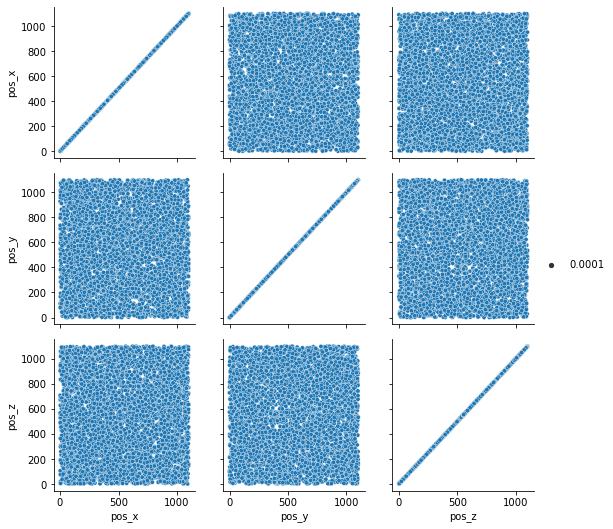

In [41]:
grid = sns.PairGrid(halo_df_sel[["pos_x","pos_y","pos_z"]])
grid.map(sns.scatterplot,size=0.0001)
grid.add_legend()
plt.show()
